<a href="https://colab.research.google.com/drive/1U9uL8PVFfAk6sELFoTGyGu8GbZVfQcnD?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fashion MNIST Convolutional Neural Network - Standard Prune**
1. Define Architecture

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

class FashionModel(nn.Module):
    def __init__(self):
        super(FashionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)

        return output

2. Train Model

In [ ]:
from torch.nn.utils import prune

def train(model, device, train_loader, optimizer):

    for batch_index, (inputs, labels) in enumerate(train_loader):
      model.train()
      inputs, labels = inputs.to(device), labels.to(device)

      output = model(inputs)
      loss = F.nll_loss(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # if batch_index in (200, 400, 600):
      #   prune.random_unstructured(model.conv1, name="weight", amount=0.4)
      #   prune.random_unstructured(model.conv2, name="weight", amount=0.4)

      if batch_index % 100 == 0:
        print('Training Progress: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            batch_index * len(inputs), len(train_loader.dataset),
            100. * batch_index / len(train_loader), loss.item()))

    to_prune = ((model.conv1, "weight"), (model.conv2, "weight"), (model.fc1, "weight"), (model.fc2, "weight"))
    prune.global_unstructured(to_prune, pruning_method=prune.L1Unstructured, amount=0.3)

3. Build Confusion Matrix/ Collect Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

def buildConfusionMatrix(model, testloader):
  # iterate over test data
  for inputs, labels in testloader:
          output = model(inputs) # Feed into Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # constant for classes
  classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, 
                       index = [i for i in classes],
                       columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.title("Confusion Matrix - Custom Pruned Model")
  plt.show()

  print(classification_report(y_true, y_pred, target_names=list(classes)))

4. Main function compiling previous steps

Training Progress: [0/60000 (0%)]	Loss: 2.307173
Training Progress: [6400/60000 (11%)]	Loss: 0.440680
pruning!
Training Progress: [12800/60000 (21%)]	Loss: 0.358171
Training Progress: [19200/60000 (32%)]	Loss: 0.360190
pruning!
Training Progress: [25600/60000 (43%)]	Loss: 0.350321
Training Progress: [32000/60000 (53%)]	Loss: 0.387584
pruning!
Training Progress: [38400/60000 (64%)]	Loss: 0.302986
Training Progress: [44800/60000 (75%)]	Loss: 0.462536
pruning!
Training Progress: [51200/60000 (85%)]	Loss: 0.461127
Training Progress: [57600/60000 (96%)]	Loss: 0.302242


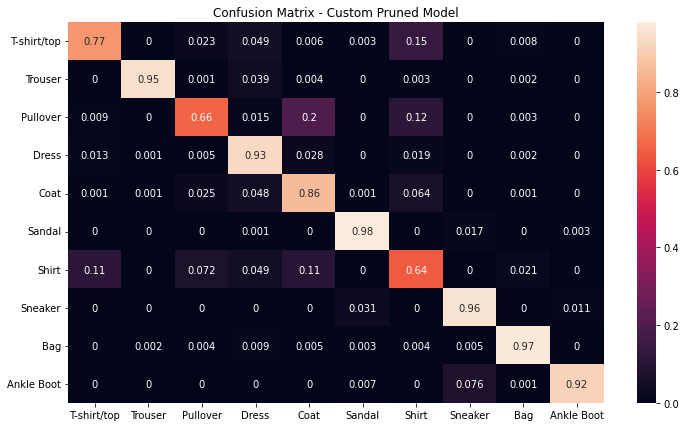

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.77      0.81      1000
     Trouser       1.00      0.95      0.97      1000
    Pullover       0.84      0.66      0.74      1000
       Dress       0.82      0.93      0.87      1000
        Coat       0.71      0.86      0.78      1000
      Sandal       0.96      0.98      0.97      1000
       Shirt       0.65      0.64      0.64      1000
     Sneaker       0.91      0.96      0.93      1000
         Bag       0.96      0.97      0.97      1000
  Ankle Boot       0.98      0.92      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



In [ ]:
def main():
    use_cuda = torch.cuda.is_available()

    torch.manual_seed(1)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    dataset1 = datasets.FashionMNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.FashionMNIST('../data', train=False,
                       transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    val_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = FashionModel().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)

    if use_cuda:
      start = torch.cuda.Event(enable_timing=True)
      end = torch.cuda.Event(enable_timing=True)

      start.record()
      train(model, device, train_loader, optimizer)
      end.record()
      torch.cuda.synchronize()
      print("\nTotal training time (1 epoch): " 
            + str(start.elapsed_time(end)/1000) + " seconds")

    else:
      train(model, device, train_loader, optimizer)
    
    buildConfusionMatrix(model, val_loader)

if __name__ == '__main__':
    main()